In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 28 days
Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 28 days


In [2]:
import numpy as np 
import numpy.ma as ma 
import pandas as pd 
from scipy.optimize import minimize 
import matplotlib.pyplot as plt
from scipy.stats import linregress

In [3]:
import sys; sys.path.append('../slip_rate_tools/')
import slip_rate_tools as srt

offset_df = pd.read_csv('../test_data/offsets.csv')
offset_df['offset_m'] = offset_df.offset_in * 200.

t1 = offset_df[offset_df.unit == 'T1']
qa = offset_df[offset_df.unit == 'Qa']
qao = offset_df[offset_df.unit == 'Qao']

#qa['offset_m'] += 200.

t1_age = {'mean': 24., 'sd':8.}
qa_age = {'mean': 50., 'sd':20.}
qao_age = {'mean':100., 'sd':32.}

#qao_age['mean'] += 200

T1 = srt.OffsetMarker(age_mean=t1_age['mean'], age_sd=t1_age['sd'],
                      offset_vals=t1.offset_m, offset_probs=t1.rel_prob)

Qa = srt.OffsetMarker(age_mean=qa_age['mean'], age_sd=qa_age['sd'],
                      offset_vals=qa.offset_m, offset_probs=qa.rel_prob)

Qao = srt.OffsetMarker(age_mean=qao_age['mean'], age_sd=qao_age['sd'],
                      offset_vals=qao.offset_m, offset_probs=qao.rel_prob)

In [4]:
def make_age_offset_arrays(offset_list, n, check_increasing=False, zero_offset_age=0.):
    
    #np.random.seed(69)
    
    
    age_array = np.zeros((n, len(offset_list)+1))
    off_array = np.zeros((n, len(offset_list)+1))
    
    age_array[:,0] = zero_offset_age
    
    for i, off_mark in enumerate(offset_list):
        col = i+1
        age_array[:,col], off_array[:,col] = off_mark.sample(n)
        
    if check_increasing == True:
        
        def make_inc_bool(age_array, off_array, n):
        
            inc_bool = np.ones((age_array.shape[0]), dtype=int)
            for row in range(n):
                age_inc = srt.check_increasing(age_array[row,:])
                off_inc = srt.check_increasing(off_array[row,:])
                
                if not (age_inc and off_inc):
                    inc_bool[row] = 0
                    
            #print('ic',inc_bool.sum())
            inc_bool = np.array(inc_bool, dtype=bool)
                
            return inc_bool
    
        inc_bool = make_inc_bool(age_array, off_array, n)
                    
        age_array = age_array[inc_bool, :]
        off_array = off_array[inc_bool, :]
        
        while age_array.shape[0] < n:
            
            next_age_array, next_off_array = make_age_offset_arrays(offset_list, n, 
                                                                    check_increasing=False,
                                                                    zero_offset_age=zero_offset_age)
            
            next_inc_bool = make_inc_bool(next_age_array, next_off_array, n)
            
            next_age_array = next_age_array[next_inc_bool, :]
            next_off_array = next_off_array[next_inc_bool, :]
           
            off_array = np.vstack([off_array, next_off_array])
            age_array = np.vstack([age_array, next_age_array])
            
            #print(age_array.shape[0])
            
    return age_array[:n,:], off_array[:n,:]

In [5]:
def piece_lin_objective(params, x_data, y_data): 
    # y1, y2, y3, x2 are scalars, data is a constant np.array 
    y1 = 0.
    y2, y3, x2 = params
    x1, x3 = x_data[0], x_data[-1] 
    Xbefore = y1 + (x_data - x1) * (y2 - y1) / (x2 - x1) 
    Xafter = y2 + (x_data - x2) * (y3 - y2) / (x3 - x2) 
    Xbreak = np.where(x_data <= x2, Xbefore, Xafter) 
    return (ma.masked_invalid(Xbreak - y_data)**2).sum()


def piece_lin_opt(x_data, y_data):
    
    init_guesses = (np.mean(y_data), np.mean(y_data), np.mean(x_data))
    bounds = ((0, np.max(y_data)), (0., np.max(y_data)), (0., np.max(y_data)))
    
    
    res = minimize(piece_lin_objective, init_guesses, (x_data, y_data),
                   method="L-BFGS-B", bounds=bounds)
    
    sum_sq_err = piece_lin_objective(res.x, x_data, y_data)
    
    y2, y3, x2 = res.x
    
    slope1 = y2 / x2
    slope2 = ((y3 - y2) / (np.max(x_data) - x2))
    breakpoint = x2
    
    return slope1, slope2, breakpoint, sum_sq_err


def lin_fit(x_data, y_data):
    x = x_data[:,np.newaxis]
    m, _, _, _ = np.linalg.lstsq(x, y_data)
    m = m[0]
    
    sum_sq_err = ((y_data - (m * x_data))**2).sum()
    
    return m, sum_sq_err

In [7]:
def log_like(sum_sq, n):
    
    return -n / 2 * np.log(sum_sq)

def like(sum_sq, n, variance=1):
    return variance**(-n / 2) * np.exp(- sum_sq / 2 * variance)


def bic(log_like, n, p):
    
    return log_like - ( 0.5 * p * np.log(n / 2 * np.pi))


def AIC(log_like, p):
    
    return 2 * p - 2 * log_like


In [6]:
n_iters = 100
age_arr, off_arr = make_age_offset_arrays([T1, Qa, Qao], n_iters, 
                                          check_increasing=True)

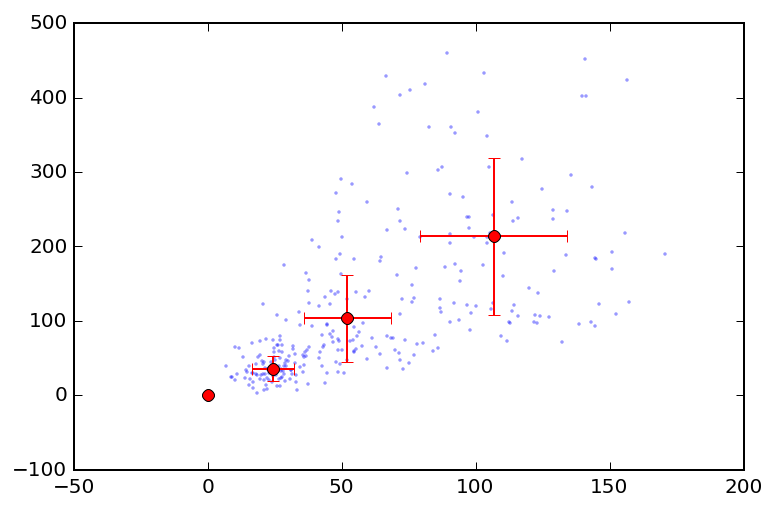

In [8]:
plt.scatter(age_arr.ravel(), off_arr.ravel(), lw=0, s=3, alpha=0.4)
plt.errorbar(np.mean(age_arr, axis=0), np.mean(off_arr, axis=0),
             xerr=np.std(age_arr, axis=0), yerr=np.std(off_arr, axis=0),
             fmt='o', c='r')
plt.show()

In [9]:
res_df = pd.DataFrame(index=np.arange(n_iters), 
                      columns=['m1', 'm2', 'breakpt', 'sumsq2', 'm', 'sumsq1'],
                      dtype='float')

In [14]:
np.hstack([age_arr, off_arr]).shape

['age_{}'.format(i) for i in range(age_arr.shape[1])]

['age_0', 'age_1', 'age_2', 'age_3', 'age_0', 'age_1', 'age_2', 'age_3']

In [16]:
def get_age_off_col_names(age_arr_shape):
    
    age_cols = ['age_{}'.format(i) for i in range(age_arr_shape[1])]
    off_cols = ['off_{}'.format(i) for i in range(age_arr_shape[1])]
    
    return age_cols + off_cols

In [17]:
all_df = pd.DataFrame(np.hstack([age_arr, off_arr]), 
                      columns=get_age_off_col_names(age_arr.shape))

In [20]:
def piece_lin_row_opt(row):
    x_inds = [col for col in row.index if 'age' in col]
    y_inds = [col for col in row.index if 'off' in col]
    
    x_data = row[x_inds]
    y_data = row[y_inds]
    
    m1, m2, breakpt, sumsq2 = piece_lin_opt(x_data, y_data)
    
    return pd.Series({'m1':m1, 'm2':m2, 'breakpt':breakpt, 'sumsq2':sumsq2})

In [23]:
%%timeit

#all_df[['m1', 'm2', 'breakpt', 'sumsq2']] = 

all_df.apply(piece_lin_row_opt, axis=1)

1 loops, best of 3: 29.7 s per loop


In [36]:
#%%timeit

for i in range(n_iters):
    xd = age_arr[i,:]
    yd = off_arr[i,:]
    
    res_df.ix[i, ['m1', 'm2', 'breakpt', 'sumsq2']]= piece_lin_opt(xd, yd)
    
    res_df.ix[i, ['m', 'sumsq1']] = lin_fit(xd, yd)
    

In [37]:
res_df.head()

,m1,m2,breakpt,sumsq2,m,sumsq1,like1,like2,loglike1,loglike2,bic1,bic2
0,2.252824,3.929101,38.595165,302.008477,2.925149,832.982513,NaN,2.628407e-66,NaN,-11.420910,NaN,-14.177726
1,0.776389,0.482212,78.384858,138.796336,0.677282,238.170000,NaN,7.257026e-31,NaN,-9.866015,NaN,-12.622831
2,0.494651,11.464004,124.232991,38.683025,1.608267,10410.957146,NaN,3.981876e-09,NaN,-7.310802,NaN,-10.067617
3,2.291379,0.325594,61.559948,90.575870,1.293349,4493.347239,NaN,2.146346e-20,NaN,-9.012376,NaN,-11.769191
4,1.329655,1.202611,35.140336,751.506427,1.257159,757.946290,NaN,6.493112e-164,NaN,-13.244160,NaN,-16.000975


In [38]:
res_df.dtypes

m1          float64
m2          float64
breakpt     float64
sumsq2      float64
m           float64
sumsq1      float64
like1       float64
like2       float64
loglike1    float64
loglike2    float64
bic1        float64
bic2        float64
dtype: object

In [39]:
res_df['like1'] = like(res_df.sumsq1, 4)
res_df['like2'] = like(res_df.sumsq2, 4)

res_df['loglike1'] = log_like(res_df.sumsq1, 4)
res_df['loglike2'] = log_like(res_df.sumsq2, 4)

res_df['bic1'] = bic(res_df.loglike1, 4, 1)
res_df['bic2'] = bic(res_df.loglike2, 4, 3)

In [40]:
res_df.describe()

,m1,m2,breakpt,sumsq2,m,sumsq1,like1,like2,loglike1,loglike2,bic1,bic2
count,100.000000,1.000000e+02,100.000000,1.000000e+02,100.000000,100.000000,1.000000e+02,1.000000e+02,100.000000,100.000000,100.000000,100.000000
mean,7.941781,6.625734e+03,51.397216,1.661552e+03,2.075203,5596.269530,1.360642e-05,1.857617e-01,-15.257804,-1.041024,-16.176742,-3.797840
std,37.760048,6.616692e+04,25.616920,5.903594e+03,1.131747,8145.390950,1.360612e-04,3.819837e-01,3.286300,23.847761,3.286300,23.847761
min,0.000000,1.281893e-08,0.139433,1.157324e-15,0.644697,13.199641,0.000000e+00,0.000000e+00,-21.508043,-21.692353,-22.426982,-24.449168
25%,1.260603,5.414687e-01,35.063278,1.271146e+01,1.221212,727.363696,0.000000e+00,2.135652e-131,-17.593669,-12.824866,-18.512607,-15.581682
50%,1.682779,1.868279e+00,52.973026,1.397934e+02,1.888170,2673.083758,0.000000e+00,4.420877e-31,-15.781976,-9.880330,-16.700915,-12.637146
75%,2.952448,4.334381e+00,69.121895,6.095434e+02,2.754577,6614.175719,2.998478e-158,1.738730e-03,-13.178841,-5.084953,-14.097779,-7.841769
max,368.567062,6.616782e+05,124.232991,5.133748e+04,5.698967,46817.933845,1.360612e-03,1.000000e+00,-5.160379,68.785332,-6.079318,66.028517


In [41]:
res_df[['bic1', 'bic2']].head()

,bic1,bic2
0,-14.368964,-14.177726
1,-11.864908,-12.622831
2,-19.420167,-10.067617
3,-17.739645,-11.769191
4,-14.180164,-16.000975


In [48]:
len(res_df[res_df.bic1 < res_df.bic2].index) / len(res_df.index)

0.73

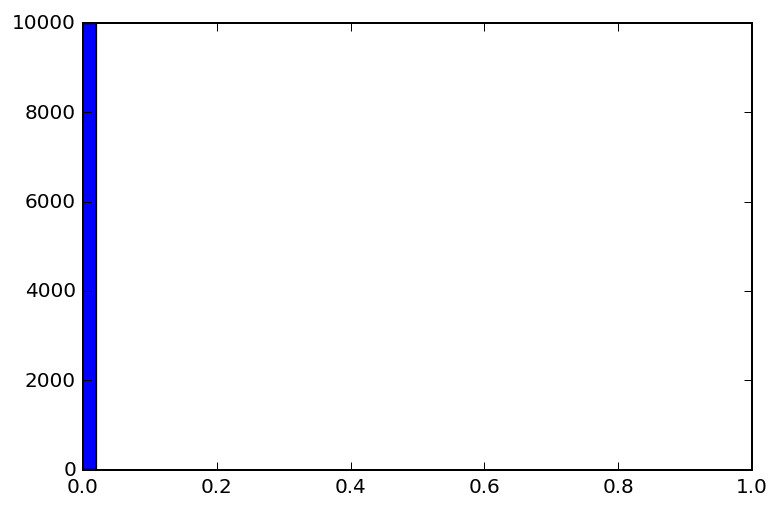

In [163]:
plt.hist( np.exp(res_df.loglike1) / np.exp(res_df.loglike1.max()), bins=50)
plt.show()

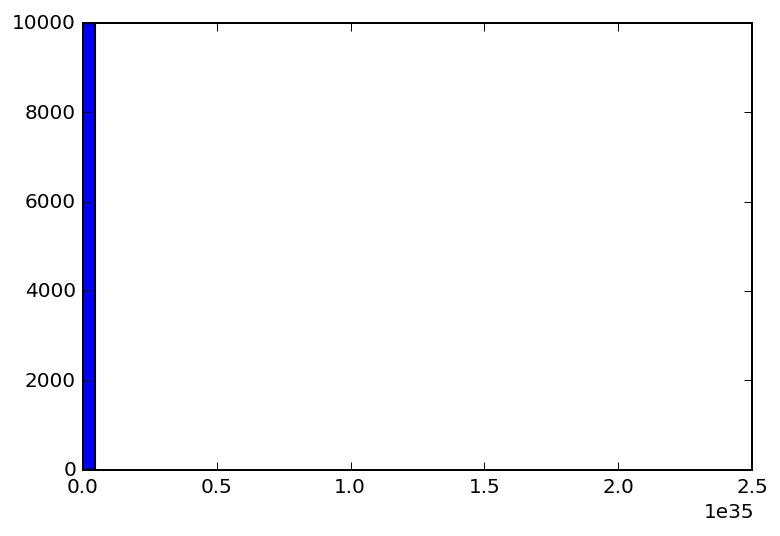

In [164]:
plt.hist( np.exp(res_df.loglike2) , bins=50)
plt.show()

In [165]:
np.exp(res_df.loglike2).describe()

count    1.000000e+04
mean     2.323101e+31
std      2.302239e+33
min      3.004667e-11
25%      9.049287e-07
50%      2.402492e-05
75%      2.948010e-03
max      2.302212e+35
Name: loglike2, dtype: float64

In [166]:
res_df[res_df.like2==res_df.like2.max()]

,m1,m2,breakpt,sumsq2,m,sumsq1,like1,like2,loglike1,loglike2,bic1,bic2
713,0.317795,2.466972,55.400702,1.050913e-16,0.786778,190.025109,5.452202e-42,1,-10.494312,73.583405,-11.413251,70.826590
7094,5.847703,0.209901,19.543751,8.955342e-17,1.742516,4083.357966,0.000000e+00,1,-16.629350,73.903393,-17.548288,71.146577
7420,5.152799,0.279542,18.667984,2.979655e-17,1.539259,1407.707209,2.090564e-306,1,-14.499435,76.104278,-15.418374,73.347463
9257,4.260188,0.492565,33.981059,2.084142e-18,1.852046,3363.794921,0.000000e+00,1,-16.241650,81.424349,-17.160589,78.667533


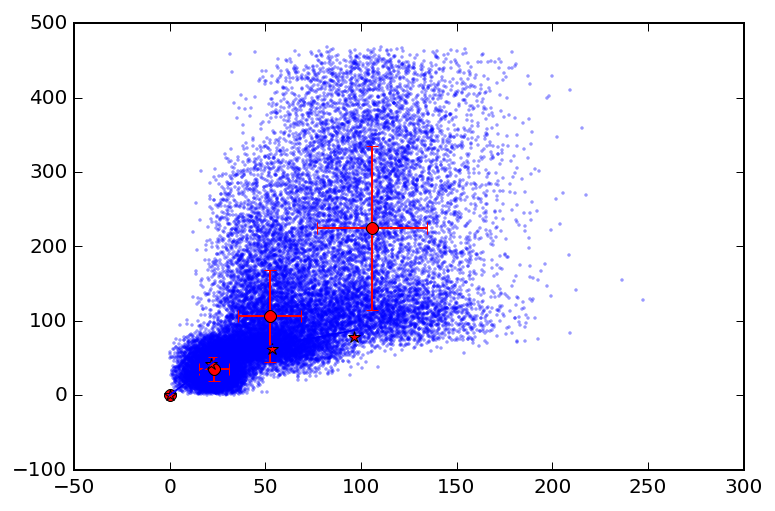

In [167]:
plt.scatter(age_arr.ravel(), off_arr.ravel(), lw=0, s=3, alpha=0.4)
plt.errorbar(np.mean(age_arr, axis=0), np.mean(off_arr, axis=0),
             xerr=np.std(age_arr, axis=0), yerr=np.std(off_arr, axis=0),
             fmt='o', color='red')

plt.plot(age_arr[921,:], off_arr[921,:], 'r*')
plot_results(res_df, age_arr, 921, lines=2)

plt.show()

In [168]:
def plot_results(res_df, age_array, row, lines=1):
    
    x_pts = age_array[row,:]
    
    row_res = res_df.iloc[row,:]
    
    if lines==1:
        y_pts = x_pts * row_res.m
    
    elif lines==2:
        x_pts = np.array([x_pts[0], row_res.breakpt, x_pts[-1]])
        y_pts = np.array([0., row_res.m1 * row_res.breakpt, 
                          row_res.m1 * row_res.breakpt + row_res.m2 * x_pts[-1]])
        
    plt.plot(x_pts, y_pts)
    

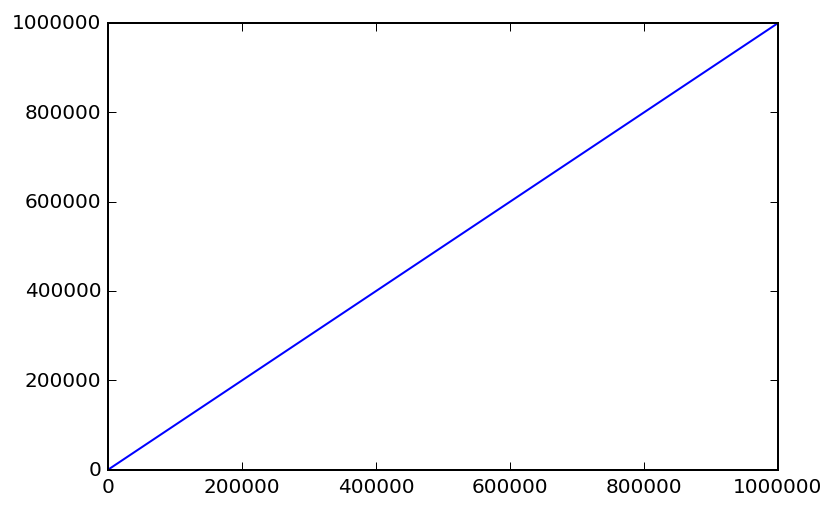

In [169]:
plt.plot(np.linspace(0, 1e6),(np.linspace(0, 1e6)))
plt.show()

In [170]:
np.exp(-1e2)

3.7200759760208361e-44

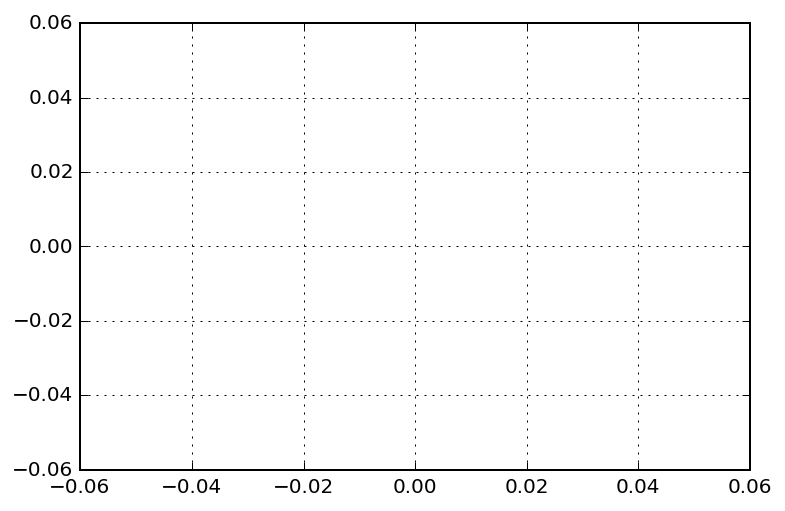

In [171]:
res_df.m1.hist(bins=50)
plt.show()

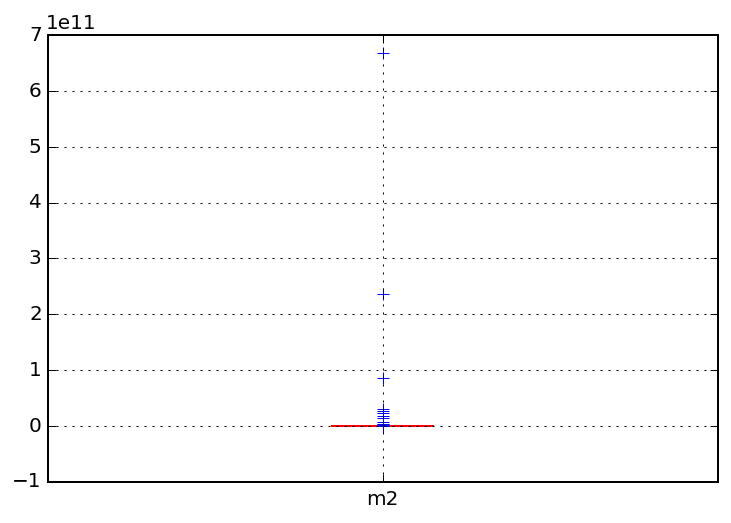

In [172]:
res_df.m2.plot(kind='box')
plt.show()

In [173]:
res_df.m1.describe()

count    1.000000e+04
mean              inf
std               NaN
min     -1.210772e-15
25%      1.231774e+00
50%      1.833976e+00
75%      2.862169e+00
max               inf
Name: m1, dtype: float64

In [174]:
res_df.breakpt.describe()

count    10000.000000
mean        53.198838
std         25.021295
min          0.000000
25%         38.065628
50%         54.559174
75%         68.895626
max        334.808558
Name: breakpt, dtype: float64

In [175]:
res_df.m.describe()

count    10000.000000
mean         2.138584
std          1.109694
min          0.413656
25%          1.237021
50%          1.930162
75%          2.819336
max         11.263149
Name: m, dtype: float64